(gallery-tutorial-collection)=

# Working with Collections

The top level class `Collection` allows users to group objects by reference for common manipulation. The idea is that

1. A collection spans its own local frame of reference with position and orientation, to which the children are added. Thus, any operation applied to the collection is individually applied to all its children.
2. The collection itself behaves like a single Magpylib object (can be source and/or observer).
3. All children inside the collection can be individually addressed and manipulated at all times.
4. Collections have their own `style` attributes, their paths are displayed in `show`, and all children are automatically assigned their parent color.

## Constructing Collections

Collections have the attributes `children`, `sources`, `sensors` and `collections`. These attributes are ordered lists that contain objects that are added to the collection by reference (not copied). `children` returns a list of all objects in the collection. `sources` returns a list of the sources, `sensors` a list of the sensors and `collections` a list of "sub-collections" within the collection.

In [1]:
import magpylib as magpy

x1 = magpy.Sensor(style_label="x1")
s1 = magpy.magnet.Cuboid(style_label="s1")
c1 = magpy.Collection(style_label="c1")

coll = magpy.Collection(x1, s1, c1, style_label="coll")

print(f"children:    {coll.children}")
print(f"sources:     {coll.sources}")
print(f"sensors:     {coll.sensors}")
print(f"collections: {coll.collections}")

children:    [Sensor(id=140544196965616, label='x1'), Cuboid(id=140544195414240, label='s1'), Collection(id=140544195164288, label='c1')]
sources:     [Cuboid(id=140544195414240, label='s1')]
sensors:     [Sensor(id=140544196965616, label='x1')]
collections: [Collection(id=140544195164288, label='c1')]


New additions are always added at the end. Use the **`add`** method or the parameters.

In [2]:
# Copy adjusts object label automatically
x2 = x1.copy()
s2 = s1.copy()
c2 = c1.copy()

# Add objects with add method
coll.add(x2, s2)

# Add objects with parameters
coll.collections += [c2]

print(f"children:    {coll.children}")
print(f"sources:     {coll.sources}")
print(f"sensors:     {coll.sensors}")
print(f"collections: {coll.collections}")

children:    [Sensor(id=140544196965616, label='x1'), Cuboid(id=140544195414240, label='s1'), Sensor(id=140544195163184, label='x2'), Cuboid(id=140544195165440, label='s2'), Collection(id=140544195164288, label='c1'), Collection(id=140543761616944, label='c2')]
sources:     [Cuboid(id=140544195414240, label='s1'), Cuboid(id=140544195165440, label='s2')]
sensors:     [Sensor(id=140544196965616, label='x1'), Sensor(id=140544195163184, label='x2')]
collections: [Collection(id=140544195164288, label='c1'), Collection(id=140543761616944, label='c2')]


The **`describe`** method is a very convenient way to view a Collection structure, especially when the collection is nested, i.e., when containing other collections.

In [3]:
# Add more objects
c1.add(x2.copy())
c2.add(s2.copy())

coll.describe(format="label+type")

Collection coll
├── Sensor x1
├── Cuboid s1
├── Sensor x2
├── Cuboid s2
├── Collection c1
│   └── Sensor x3
└── Collection c2
    └── Cuboid s3


The parameter `format` can be any combination of `"type"`, `"label"`, `"id"` and `"properties"`.

For convenience, any two Magpylib objects can be added up with `+` to form a collection.

In [4]:
import magpylib as magpy

x1 = magpy.Sensor(style_label="x1")
s1 = magpy.magnet.Cuboid(style_label="s1")

coll = x1 + s1

coll.describe(format="label")

Collection
├── x1
└── s1


## Child-Parent Relations

Objects that are part of a collection become children of that collection, and the collection itself becomes their parent. Every Magpylib object has the `parent` attribute, which is `None` by default.

In [5]:
import magpylib as magpy

x1 = magpy.Sensor()
c1 = magpy.Collection(x1)

print(f"x1.parent:   {x1.parent}")
print(f"c1.parent:   {c1.parent}")
print(f"c1.children: {c1.children}")

x1.parent:   Collection(id=140544195165392)
c1.parent:   None
c1.children: [Sensor(id=140544195160784)]


Rather than adding objects to a collection, as described above, one can also set the `parent` parameter. A Magpylib object can only have a single parent, i.e., it can only be part of a single collection. As a result, changing the parent will automatically remove the object from its previous collection.

In [6]:
import magpylib as magpy

x1 = magpy.Sensor(style_label="x1")
c1 = magpy.Collection(style_label="c1")
c2 = magpy.Collection(c1, style_label="c2")

print("Two empty, nested collections")
c2.describe(format="label")

print("\nSet x1 parent to c1")
x1.parent = c1
c2.describe(format="label")

print("\nChange x1 parent to c2")
x1.parent = c2
c2.describe(format="label")

Two empty, nested collections
c2
└── c1

Set x1 parent to c1
c2
└── c1
    └── x1

Change x1 parent to c2
c2
├── c1
└── x1


## Accessing Children

Collections have `__getitem__` through the attribute `children` defined which enables using collections directly as iterators,

In [7]:
import magpylib as magpy

x1 = magpy.Sensor()
x2 = magpy.Sensor()

coll = x1 + x2

for child in coll:
    print(child)

Sensor(id=140544195151760)
Sensor(id=140544195161120)


and makes it possible to directly reference to a child object by index:

In [8]:
print(coll[0])

Sensor(id=140544195151760)


Collection nesting is powerful to create a self-consistent hierarchical structure, however, it is often in the way of quick child access in nested trees. For this, the `children_all`, `sources_all`, `sensors_all` and `collections_all` read-only parameters, return all objects in the tree:

In [9]:
import magpylib as magpy

s1 = magpy.Sensor(style_label="s1")
s2 = s1.copy()
s3 = s2.copy()

# this creates a nested collection
coll = s1 + s2 + s3
coll.describe(format="label")

# _all gives access to the whole tree
print([s.style.label for s in coll.sensors_all])

Collection
├── Collection
│   ├── s1
│   └── s2
└── s3
['s1', 's2', 's3']


## Practical Example

The following example demonstrates how collections enable user-friendly manipulation of groups, sub-groups and individual objects.

In [10]:
import numpy as np

import magpylib as magpy

# Construct two coils from windings
coil1 = magpy.Collection(style_label="coil1")
for z in np.linspace(-0.0005, 0.0005, 5):
    coil1.add(magpy.current.Circle(current=1, diameter=0.02, position=(0, 0, z)))
coil1.position = (0, 0, -0.005)
coil2 = coil1.copy(position=(0, 0, 0.005))

# Helmholtz consists of two coils
helmholtz = coil1 + coil2

# Move the helmholtz
helmholtz.position = np.linspace((0, 0, 0), (0.01, 0, 0), 15)
helmholtz.rotate_from_angax(np.linspace(0, 180, 15), "x", start=0)

# Move the coils
coil1.move(np.linspace((0, 0, 0), (0.005, 0, 0), 15))
coil2.move(np.linspace((0, 0, 0), (-0.005, 0, 0), 15))

# Move the windings
for coil in [coil1, coil2]:
    for i, wind in enumerate(coil):
        wind.move(np.linspace((0, 0, 0), (0, 0, (2 - i) * 0.001), 15))

# Display as animation
magpy.show(*helmholtz, animation=True, style_path_show=False)

For magnetic field computation, a collection with source children behaves like a single source object, and a collection with sensor children behaves like a flat list of its sensors when provided as `sources` and `observers` input respectively.

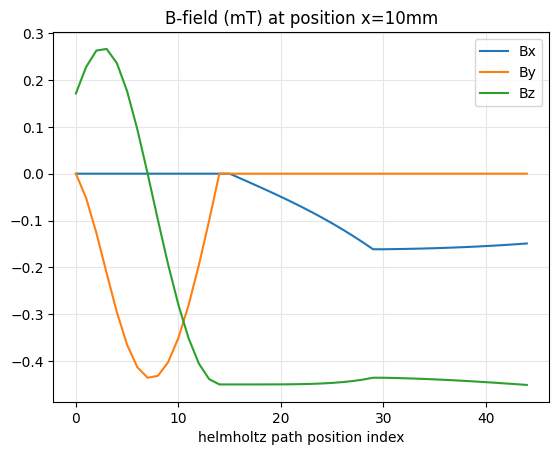

In [11]:
import matplotlib.pyplot as plt

B = magpy.getB(helmholtz, (0.01, 0, 0))
plt.plot(
    B * 1000,  # T -> mT
    label=["Bx", "By", "Bz"],
)

plt.gca().set(
    title="B-field (mT) at position x=10mm", xlabel="helmholtz path position index"
)
plt.gca().grid(color=".9")
plt.gca().legend()
plt.show()

## Efficient 3D Models

The graphical backend libraries were not designed for complex 3D graphic output. As a result, it becomes often inconvenient and slow when attempting to display many 3D objects. One solution to this problem when dealing with large collections is to represent the latter by a single encompassing body, and to deactivate the individual 3D models of all children.

In [12]:
import magpylib as magpy

# Create collection
coll = magpy.Collection()
for index in range(10):
    cuboid = magpy.magnet.Cuboid(
        polarization=(0, 0, (index % 2 - 0.5)),
        dimension=(0.01, 0.01, 0.01),
        position=(index * 0.01, 0, 0),
    )
    coll.add(cuboid)

# Add an encompassing 3D-trace
trace = magpy.graphics.model3d.make_Cuboid(
    dimension=(0.104, 0.012, 0.012),
    position=(0.045, 0, 0),
    opacity=0.5,
)
coll.style.model3d.add_trace(trace)

coll.style.label = "Collection with visible children"
coll.show()

# Hide the children default 3D representation
coll.set_children_styles(model3d_showdefault=False)
coll.style.label = "Collection with hidden children"
coll.show()

## Compound Objects

Collections can be subclassed to form dynamic groups that seamlessly integrate into Magpylib. Such classes are referred to as **compounds**. An example how this is done is shown in {ref}`gallery-misc-compound`.